>>> [Step 1] 数据加载与 Scaler 校准...
>>> [Step 2] 加载预训练模型...
>>> [Step 3] 执行消融实验 (顺序已按要求修改)...


Testing Full Model:   0%|          | 0/103 [00:00<?, ?it/s]

Testing Only GNN:   0%|          | 0/103 [00:00<?, ?it/s]

Testing Only 3D CNN:   0%|          | 0/103 [00:00<?, ?it/s]

Testing Only Descriptors:   0%|          | 0/103 [00:00<?, ?it/s]

Testing No Graph Struct:   0%|          | 0/103 [00:00<?, ?it/s]

Testing No 3D Coords:   0%|          | 0/103 [00:00<?, ?it/s]

Testing No Chem Desc:   0%|          | 0/103 [00:00<?, ?it/s]


>>> [Step 4] 可视化分析 (Arial Bold + No Title + Boxed + Clean R2)...


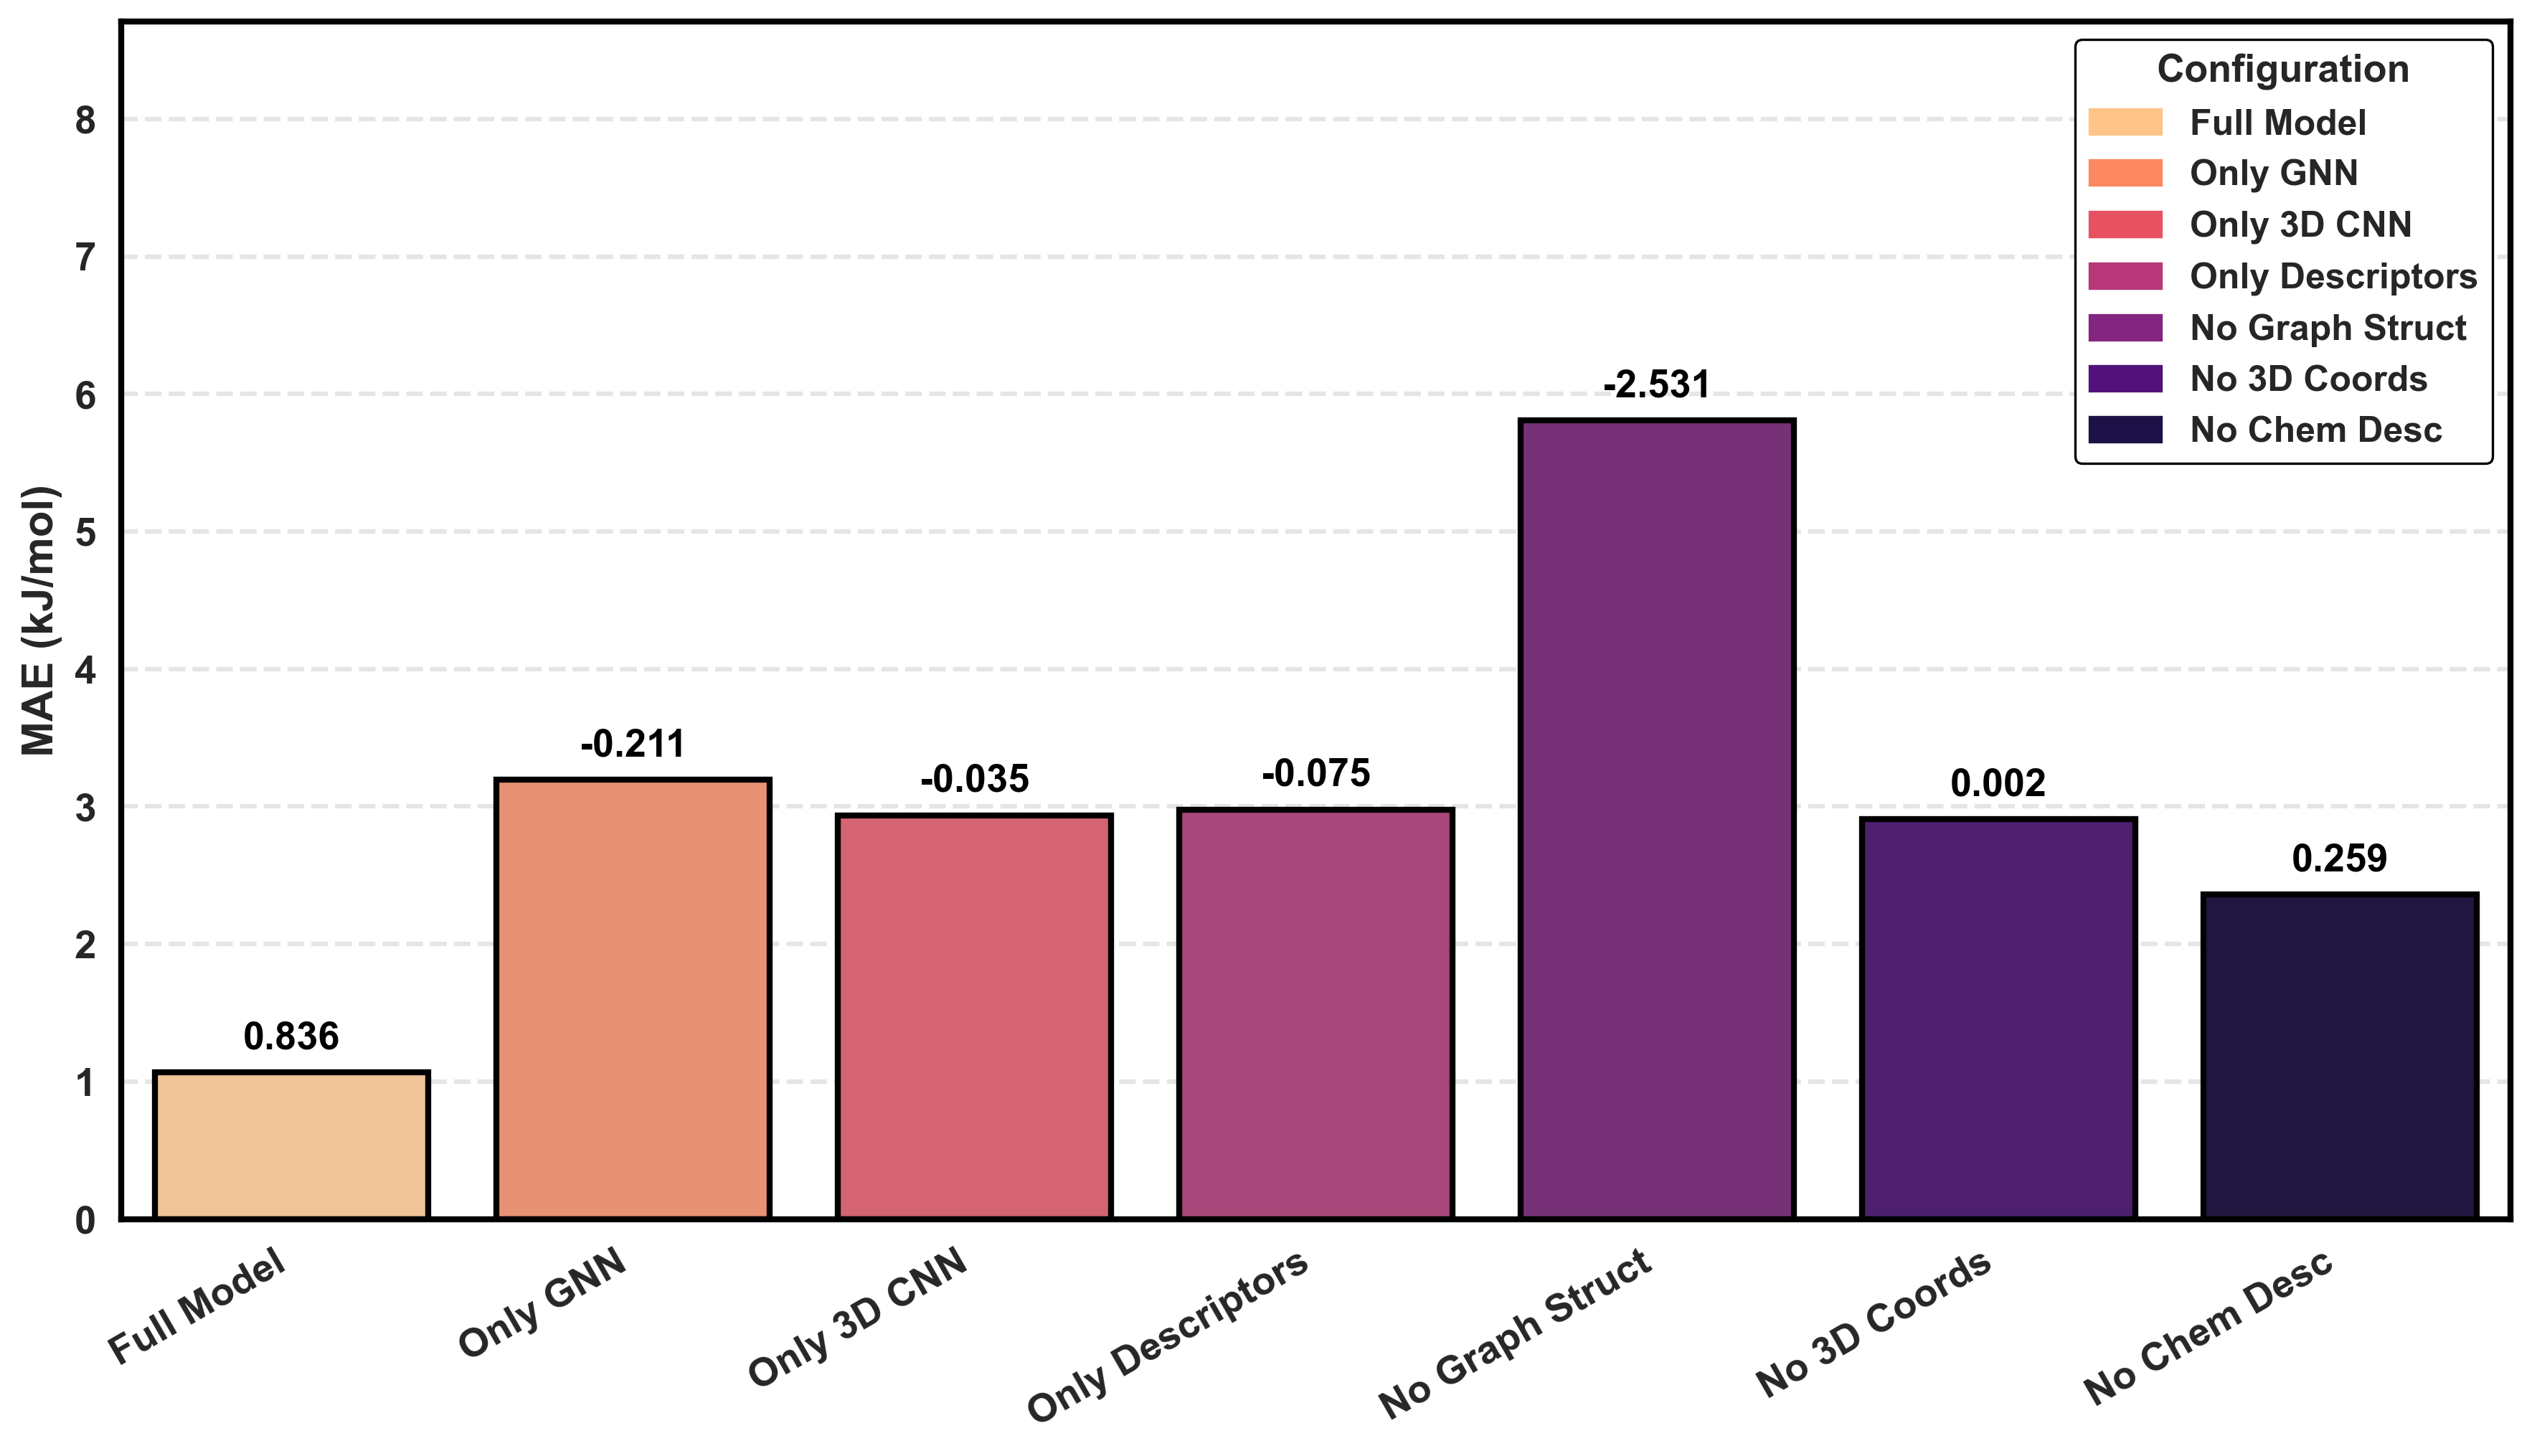


FINAL ANALYSIS REPORT
                    MAE   RMSE      R2  MAE_Increase
Configuration                                       
Full Model       1.0663 1.5023  0.8361        0.0000
Only GNN         3.1946 4.0833 -0.2112        2.1283
Only 3D CNN      2.9363 3.7747 -0.0350        1.8700
Only Descriptors 2.9779 3.8473 -0.0752        1.9116
No Graph Struct  5.8070 6.9722 -2.5311        4.7407
No 3D Coords     2.9057 3.7074  0.0016        1.8393
No Chem Desc     2.3604 3.1930  0.2594        1.2941
图片已保存至: Ablation_Final_Clean_R2_Boxed.png


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Batch, Dataset
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tqdm.notebook import tqdm


torch.serialization.add_safe_globals([Batch, Dataset])

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.weight'] = 'bold'          
plt.rcParams['axes.labelweight'] = 'bold'     
plt.rcParams['axes.titleweight'] = 'bold'     
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.linewidth'] = 2.0          

sns.set_context("paper", font_scale=1.5)
sns.set_style("white") 

class Config:
    BASE_PATH = r"./data"
    DATASET_PATH = os.path.join(BASE_PATH, "Energy_data.xlsx")
    PROCESSED_CACHE_PATH = r"./models/cached_graphs_box64_cleaned.pt"
    MODEL_PATH = r"./models/zeolite_3d_gnn_enriched_cleaned.pth"

    ATOM_EMBEDDING_DIM = 64
    HIDDEN_DIM = 128
    EMB_DIM_DEGREE = 8
    EMB_DIM_CHARGE = 8
    EMB_DIM_HYB = 8
    EMB_DIM_AROMATIC = 4
    EMB_DIM_CHIRAL = 4
    VOXEL_SIZE = 64
    VOXEL_RES = 0.5
    SIGMA = 0.5
    MIN_SAMPLES_PER_TOPO = 0 
    TARGET_COLS = [
        'Binding Energy (kJ/mol Si)',
        'Directivity Energy (kJ/mol Si)',
        'Competition Energy (kJ/mol Si)',
        'Binding Energy (kJ/mol OSDA)',
        'Competition Energy (kJ/mol OSDA)'
    ]


def coords_to_voxel(coords, grid_size=64, res=0.5, sigma=0.5):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    limit = (grid_size * res) / 2.0
    mask = (coords[:, 0] > -limit) & (coords[:, 0] < limit) & \
           (coords[:, 1] > -limit) & (coords[:, 1] < limit) & \
           (coords[:, 2] > -limit) & (coords[:, 2] < limit)
    valid_coords = coords[mask]
    if len(valid_coords) == 0: return grid
    indices = ((valid_coords + limit) / res).astype(int)
    indices = np.clip(indices, 0, grid_size - 1)
    for idx in indices:
        x, y, z = idx
        x_min, x_max = max(0, x-1), min(grid_size, x+2)
        y_min, y_max = max(0, y-1), min(grid_size, y+2)
        z_min, z_max = max(0, z-1), min(grid_size, z+2)
        grid[x_min:x_max, y_min:y_max, z_min:z_max] += 1.0
    return np.clip(grid, 0, 1.0)

class ZeoliteInferenceDataset(Dataset):
    def __init__(self, df, cache_data, target_scaler, props_scaler):
        super().__init__()
        self.df = df
        self.target_scaler = target_scaler
        self.props_scaler = props_scaler
        self.mol_cache = cache_data['mol_cache']
        self.zeo_cache = cache_data['zeo_cache']
        self.valid_indices = []
        for idx, row in df.iterrows():
            if row['CID'] in self.mol_cache and row['Topology Code'] in self.zeo_cache:
                self.valid_indices.append(idx)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        real_idx = self.valid_indices[idx]
        row = self.df.loc[real_idx]
        mol_data = self.mol_cache[row['CID']].clone()
        zeo_data = self.zeo_cache[row['Topology Code']].clone()
        
        props_raw = mol_data.global_attr.numpy()
        props_norm = self.props_scaler.transform(props_raw)
        mol_data.global_attr = torch.tensor(props_norm, dtype=torch.float)
        
        mol_coords = mol_data.pos_variants[0].numpy() if hasattr(mol_data, 'pos_variants') else mol_data.pos.numpy()
        if hasattr(mol_data, 'pos_variants'): del mol_data.pos_variants
        mol_data.pos = torch.tensor(mol_coords, dtype=torch.float)
        
        zeo_coords = zeo_data.pos_super.numpy() if hasattr(zeo_data, 'pos_super') else zeo_data.pos.numpy()
        if hasattr(zeo_data, 'pos_super'): del zeo_data.pos_super
        
        grid_mol = coords_to_voxel(mol_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        grid_zeo = coords_to_voxel(zeo_coords, Config.VOXEL_SIZE, Config.VOXEL_RES, Config.SIGMA)
        voxel_tensor = torch.tensor(np.stack([grid_mol, grid_zeo], axis=0), dtype=torch.float)
        
        y_raw = row[Config.TARGET_COLS].values.astype(float)
        return mol_data, zeo_data, voxel_tensor, torch.tensor(y_raw, dtype=torch.float)

    @staticmethod
    def gpu_collate(batch):
        mol_list, zeo_list, voxel_list, y_list = zip(*batch)
        return (Batch.from_data_list(mol_list), Batch.from_data_list(zeo_list), 
                torch.stack(voxel_list), torch.stack(y_list))

class Voxel3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 16, 3, padding=1); self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1); self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d(2)
        self.fc = nn.Linear(64 * 8 * 8 * 8, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return F.relu(self.fc(x))

class DualBranchGNN_Ablation(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_atom = nn.Embedding(120, Config.ATOM_EMBEDDING_DIM)
        self.emb_degree = nn.Embedding(12, Config.EMB_DIM_DEGREE)
        self.emb_charge = nn.Embedding(15, Config.EMB_DIM_CHARGE)
        self.emb_hyb = nn.Embedding(8, Config.EMB_DIM_HYB)
        self.emb_aromatic = nn.Embedding(2, Config.EMB_DIM_AROMATIC)
        self.emb_chiral = nn.Embedding(4, Config.EMB_DIM_CHIRAL)
        
        total_emb_dim = (Config.ATOM_EMBEDDING_DIM + Config.EMB_DIM_DEGREE + 
                         Config.EMB_DIM_CHARGE + Config.EMB_DIM_HYB + 
                         Config.EMB_DIM_AROMATIC + Config.EMB_DIM_CHIRAL)
        
        self.mol_conv1 = GCNConv(total_emb_dim + 1, Config.HIDDEN_DIM)
        self.mol_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.zeo_conv1 = GCNConv(total_emb_dim, Config.HIDDEN_DIM)
        self.zeo_conv2 = GCNConv(Config.HIDDEN_DIM, Config.HIDDEN_DIM)
        self.voxel_cnn = Voxel3DCNN()
        self.global_encoder = nn.Sequential(
            nn.Linear(17, 64), nn.ReLU(),
            nn.Linear(64, Config.HIDDEN_DIM), nn.BatchNorm1d(Config.HIDDEN_DIM), nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(Config.HIDDEN_DIM * 4, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, len(Config.TARGET_COLS))
        )

    def _embed_features(self, x_idx):
        return torch.cat([
            self.emb_atom(x_idx[:, 0]), self.emb_degree(x_idx[:, 1]),
            self.emb_charge(x_idx[:, 2]), self.emb_hyb(x_idx[:, 3]),
            self.emb_aromatic(x_idx[:, 4]), self.emb_chiral(x_idx[:, 5])
        ], dim=1)

    def forward(self, mol_batch, zeo_batch, voxel_batch, ablation_mode=None):
        edge_weight_m = mol_batch.edge_weight
        if ablation_mode == 'no_graph':
            edge_weight_m = torch.zeros_like(edge_weight_m)
        elif ablation_mode == 'no_3d':
            edge_weight_m = torch.ones_like(edge_weight_m)
        edge_index_z = zeo_batch.edge_index

        x_m_in = torch.cat([self._embed_features(mol_batch.x), mol_batch.x_charge], dim=1)
        x_m = F.relu(self.mol_conv1(x_m_in, mol_batch.edge_index, edge_weight=edge_weight_m))
        x_m = F.relu(self.mol_conv2(x_m, mol_batch.edge_index, edge_weight=edge_weight_m))
        feat_m = global_mean_pool(x_m, mol_batch.batch)

        x_z = F.relu(self.zeo_conv1(self._embed_features(zeo_batch.x), edge_index_z))
        x_z = F.relu(self.zeo_conv2(x_z, edge_index_z))
        feat_z = global_mean_pool(x_z, zeo_batch.batch)

        if ablation_mode == 'no_3d':
            feat_v = self.voxel_cnn(torch.zeros_like(voxel_batch))
        else:
            feat_v = self.voxel_cnn(voxel_batch)

        global_attr = mol_batch.global_attr
        if global_attr.dim() == 3: global_attr = global_attr.squeeze(1)
        
        if ablation_mode == 'no_desc':
            feat_global = self.global_encoder(torch.zeros_like(global_attr))
        else:
            feat_global = self.global_encoder(global_attr)

        if ablation_mode == 'only_gnn':
            feat_v = torch.zeros_like(feat_v); feat_global = torch.zeros_like(feat_global)
        elif ablation_mode == 'only_cnn':
            feat_m = torch.zeros_like(feat_m); feat_z = torch.zeros_like(feat_z); feat_global = torch.zeros_like(feat_global)
        elif ablation_mode == 'only_desc':
            feat_m = torch.zeros_like(feat_m); feat_z = torch.zeros_like(feat_z); feat_v = torch.zeros_like(feat_v)
            
        return self.head(torch.cat([feat_m, feat_z, feat_global, feat_v], dim=1))


if __name__ == "__main__":
    print("Data loading")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    df = pd.read_excel(Config.DATASET_PATH, engine='openpyxl')
    topo_counts = df['Topology Code'].value_counts()
    valid_topos = topo_counts[topo_counts >= Config.MIN_SAMPLES_PER_TOPO].index
    df_filtered = df[df['Topology Code'].isin(valid_topos)].reset_index(drop=True)
    cache_data = torch.load(Config.PROCESSED_CACHE_PATH, weights_only=False)
    
    indices = list(range(len(df_filtered)))
    train_idx, temp_idx = train_test_split(indices, train_size=0.8, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, train_size=0.5, random_state=42)
    
    temp_train_y, temp_train_props = [], []
    for i in train_idx:
        row = df_filtered.iloc[i]
        if row['CID'] in cache_data['mol_cache'] and row['Topology Code'] in cache_data['zeo_cache']:
            temp_train_y.append(row[Config.TARGET_COLS].values)
            temp_train_props.append(cache_data['mol_cache'][row['CID']].global_attr.numpy())
            
    target_scaler = StandardScaler().fit(np.vstack(temp_train_y))
    props_scaler = StandardScaler().fit(np.vstack(temp_train_props).squeeze())
    
    test_dataset = ZeoliteInferenceDataset(df_filtered.iloc[test_idx].reset_index(drop=True), cache_data, target_scaler, props_scaler)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=ZeoliteInferenceDataset.gpu_collate)

    print("Loading pre-trained models")
    model = DualBranchGNN_Ablation().to(device)
    model.load_state_dict(torch.load(Config.MODEL_PATH, map_location=device), strict=True)
    model.eval()

    print(">>> [Step 3] ablation experiment...")

    ablation_modes = [
        'Full Model', 
        'Only GNN', 'Only 3D CNN', 'Only Descriptors', 
        'No Graph Struct',  
        'No 3D Coords',    
        'No Chem Desc'
    ]
    
    mode_map = {
        'Full Model': 'original',
        'Only GNN': 'only_gnn', 'Only 3D CNN': 'only_cnn', 'Only Descriptors': 'only_desc',
        'No 3D Coords': 'no_3d', 'No Graph Struct': 'no_graph', 'No Chem Desc': 'no_desc'
    }
    
    results_list = []
    for display_name in ablation_modes:
        internal_mode = mode_map[display_name]
        preds, targets = [], []
        with torch.no_grad():
            for mol, zeo, voxel, y in tqdm(test_loader, desc=f"Testing {display_name}", leave=False):
                mol, zeo, voxel = mol.to(device), zeo.to(device), voxel.to(device)
                output = model(mol, zeo, voxel, ablation_mode=internal_mode)
                pred_raw = target_scaler.inverse_transform(output.cpu().numpy())
                preds.append(pred_raw); targets.append(y.numpy())
        
        y_pred, y_true = np.vstack(preds), np.vstack(targets)
        results_list.append({
            'Configuration': display_name,
            'MAE': mean_absolute_error(y_true[:, 0], y_pred[:, 0]),
            'RMSE': np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0])),
            'R2': r2_score(y_true[:, 0], y_pred[:, 0])
        })

    ablation_df = pd.DataFrame(results_list)
    ablation_df.set_index('Configuration', inplace=True)
    ablation_df['MAE_Increase'] = ablation_df['MAE'] - ablation_df.loc['Full Model', 'MAE']

    print("\n>>> [Step 4] visual analysis (Arial Bold + No Title + Boxed + Clean R2)...")
    
    plt.figure(figsize=(12, 7)) 
    
    colors = sns.color_palette("magma", n_colors=len(ablation_df))
    colors = list(reversed(colors)) 
    
    ax = sns.barplot(
        data=ablation_df,
        x=ablation_df.index, 
        y='MAE', 
        hue=ablation_df.index,
        palette=colors, 
        edgecolor='black', 
        linewidth=2.0, 
        legend=False
    )
    
    
    plt.ylabel('MAE (kJ/mol)')
    plt.xlabel('')
    plt.xticks(rotation=30, ha='right') 
    
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('black')
        
    plt.grid(axis='y', linestyle='--', alpha=0.5, linewidth=1.5) 
    
    legend_patches = [mpatches.Patch(color=colors[i], label=label) 
                      for i, label in enumerate(ablation_df.index)]
    

    plt.legend(handles=legend_patches, 
               title='Configuration',
               loc='upper right', 
               frameon=True, 
               framealpha=1.0,     
               edgecolor='black',
               fontsize=12, 
               title_fontsize=13)
    
    y_max = ablation_df['MAE'].max()
    ax.set_ylim(0, y_max * 1.5) 
    
    for i, (idx, row) in enumerate(ablation_df.iterrows()):
        mae_val = row['MAE']
        r2_val = row['R2']
        
        label_text = f"{r2_val:.3f}"
        
        ax.text(i, mae_val + (y_max * 0.02), label_text, 
                ha='center', va='bottom', 
                color='black', fontsize=13) 
            
    plt.tight_layout()
    save_name = 'Ablation_Final_Clean_R2_Boxed.png'
    plt.savefig(save_name, dpi=300)
    plt.show()

    print("\n" + "="*40)
    print("FINAL ANALYSIS REPORT")
    print("="*40)
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(ablation_df[['MAE', 'RMSE', 'R2', 'MAE_Increase']])
    print("="*40)
    print(f"chart saved: {save_name}")